In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
# from langchain import LangChain
import PyPDF2
# import pypdf2 as PyPDF2
from io import StringIO
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.prompts import  MessagesPlaceholder, PromptTemplate, ChatPromptTemplate
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferWindowMemory
import os

In [2]:

ai_avatar  = "🤖"
user_avatar = "💬"

import PyPDF2

def read_pdf(file):
    
    # stringio = StringIO(file.getvalue().decode("utf-8"))
     # To read file as bytes:
    # bytes_data = file.getvalue()
    # To convert to a string based IO:
    # stringio = StringIO(file.getvalue())#.decode("utf-8"))

    # pdf_file_obj = open(file.name, 'rb')
    # pdf_file_obj = open(file.getvalue(),'rb')
    pdf_reader = PyPDF2.PdfReader(file)
    text = ""
    for page_num in range(len(pdf_reader.pages)):
        # page_obj = pdf_reader.getPage(page_num)
        page_obj = pdf_reader.pages[page_num]
        text += page_obj.extract_text()
    # pdf_file_obj.close()
    return text

In [3]:
def get_template_string():
    
    return """You are a a specialized career coach for the data science and analytics sector, focused on delivering tailored, concise job application advice. 
    You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.
    When analyzing a resume vs. a job listing, start by categorizing a user's fit for a job as 'perfect,' 'great,' 'good,' or 'non-ideal' based on the resume and job listing comparison before going into detail.
    You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable, with the goal of enhancing user confidence and aiding their career progression.
    """

In [4]:
model_type = st.sidebar.radio("GPT Model", options=["gpt-3.5-turbo-0125", "gpt-3.5-turbo-instruct","gpt-4-turbo-preview"],
                              index=0)

def get_llm(model_type=model_type, temperature=0.1, #verbose=False,
             template_string_func=get_template_string):

    ## get prompt string
    system_prompt = template_string_func()
    
    prompt_template =system_prompt+"""
    Current conversation:
    {history}
    Human: {input}
    AI:"""
    prompt = ChatPromptTemplate.from_template(prompt_template)
    llm = ChatOpenAI(temperature=.1, model=model_type)
    llm_chain = ConversationChain(prompt=prompt, llm=llm, memory=ConversationBufferWindowMemory(),#ConversationBufferMemory(memory_key="history"),
                                  verbose=True, output_key="response")#,#callbacks=callbacks)
    
    # llm_chain.memory.chat_memory.add_sy (template)
    return llm_chain


2024-04-26 17:58:03.866 
  command:

    streamlit run /opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [5]:

def fake_streaming(response):
    import time
    for word in response.split(" "):
        yield word + " "
        time.sleep(.05)		
        
            
    
## For steramlit try this as raw code, not a function
def print_history(llm_chain):
    # Simulate streaming for final message

    session_state_messages = llm_chain.memory.buffer_as_messages
    for msg in session_state_messages:#[:-1]:
        if isinstance(msg, AIMessage):
            # notebook
            print(f"Assistant: {msg.content}")
            # streamlit
            st.chat_message("assistant", avatar=ai_avatar).write(msg.content)
        
        elif isinstance(msg, HumanMessage):
            # notebook
            print(f"User: {msg.content}")
            # streamlit
            st.chat_message("user", avatar=user_avatar).write(msg.content)
        print()




def get_context_strings(context_resume=None, context_job=None,):
    if context_resume is None:
        context_resume = st.session_state.resume_text
    
    if context_job is None:
        context_job = st.session_state.job_listing_text
    # task_prompt_dict = get_task_options(options_only=False)
    # system_prompt = task_prompt_dict[selected_task]
    
    # template_assistant = "You are a helpful assistant data scientist who uses NLP analysis of customer reviews to inform business-decision-making:"
    # product_template = f" Assume all user questions are asking about the content in the user reviews. Note the product metadata is:\n```{product_string}```\n\n"
    # template_starter = get_template_string()
    context = f"\nHere is my resume: \n\n-------------\n {context_resume}.\n\n Here is the job listing:\n\n-------------\n{context_job}.\n\n"
    # context += f"Use the {context_type} first before using the retrieved documents."
    # template_assistant=template_starter+ context
    return context


def get_task_options(options_only=False):
    task_prompt_dict= {
        # "Summary of Customer Sentiment":'Provide a summary list of what 1-star reviews did not like and a summary of what did 5-star reviews liked.',
                   'Compare Resume vs. Job':'How does my resume compare against this job listing? Provide a detailed break down list comparing my resume vs. the listing. Highlight any weaknesses.',
                   'Craft Covert Letter':'Write a cover letter for this job. Use a non-traditional opening sentence that is very enthusiastic about the job and memorable (you can even use !). The reamining portions of the letter should be high quality and speak to my experience.',
                   "Interview Prep":'Help me prepare for an interview. Start with a question that I should expect in the interview.',
                   "Resume Analysis":'Analyze my resume. Start with a summary of my resume.',}

    if options_only:
        return list(task_prompt_dict.keys())
    else:
        return task_prompt_dict


In [6]:
task_options = get_task_options(options_only=False)
task_options

{'Compare Resume vs. Job': 'How does my resume compare against this job listing? Provide a detailed break down list comparing my resume vs. the listing. Highlight any weaknesses.',
 'Craft Covert Letter': 'Write a cover letter for this job. Use a non-traditional opening sentence that is very enthusiastic about the job and memorable (you can even use !). The reamining portions of the letter should be high quality and speak to my experience.',
 'Interview Prep': 'Help me prepare for an interview. Start with a question that I should expect in the interview.',
 'Resume Analysis': 'Analyze my resume. Start with a summary of my resume.'}

### Rethinking the Prompt

In [7]:
selected_task = 'Compare Resume vs. Job'
prompt_text =  task_options[selected_task]
print(prompt_text)


How does my resume compare against this job listing? Provide a detailed break down list comparing my resume vs. the listing. Highlight any weaknesses.


In [8]:
resume = read_pdf('data/James Irving Resume 2024.pdf')
print(resume[:1000])

JAMES M. IRVING, PH.D. 8222 Spadderdock Way, Laurel, MD, 20724 | (518) 322-6750 | james.irving.phd@gmail.com |  LINKEDIN: james-irving-phd | GITHUB: https://github.com/jirvingphd  SUMMARY Innovative and enterprising data scientist. Experienced in applying advanced data science techniques to real-world problems, including statistical modeling, machine learning, and data visualization. Skilled at extracting valuable insights from complex datasets and supporting data-driven decision-making. Adept Python programmer with the demonstrated ability to rapidly master and apply new technologies. A highly analytical professional committed to continuous learning and leveraging the value of data to innovate and transform. Former neuroscience researcher with a solid foundation in science, experimental design, and cognitive neuroscience. COMPETENCIES • Data Analysis • Statistical Modeling • Machine Learning • Data Visualization • Experimental Design • Quantitative Research Methods • Time Series Analy

In [9]:
job = read_pdf('data/Data Scientist - Focus School Software _ Remote.pdf')
print(job[:1000])

4/4/24, 2:48 PM Data Scientist - Focus School Software | Remote
https://www.simplyhired.com/job/lxgFxvpAXhH6zOMvh9G6pzooFKCORCgkfSudwEuQZAQjF7dORlMCSw?from=smart-apply 1/4Post Jobs
D t  Scientist
Focus School Softw re
Remote
Job Det ils
Full-time
$91,751.28 - $110,496.16   ye r
2 d ys   o
Beneﬁts
He lth s vin s  ccount Dis bility insur nce He lth insur nce
Dent l insur nce 401(k) Flexible spendin   ccount P id time off
Vision insur nce 401(k) m tchin  Life insur nce
Qu liﬁc tions
Power BI Writin  skills D t   n lysis skills Rese rch 3 ye rs
SQL Re ression  n lysis 2 ye rs Communic tion skills An lytics
Full Job Description
Focus is lookin  for ener etic, cre tive,  nd experienced c ndid tes who c n help us
succeed in our mission to serve  n incre sin  number of districts  cross the n tion. We
keep our clients’ needs  t the forefront of everythin  we do. As   comp ny who
underst nds the h rd work of tod y’s educ tors, Focus looks for employees who sh re our
v lues tow rds educ tion.
Foc

___

## Run Above Here to Load PDFs

In [10]:
context = get_context_strings(resume,job)
context


'\nHere is my resume: \n\n-------------\n JAMES M. IRVING, PH.D. 8222 Spadderdock Way, Laurel, MD, 20724 | (518) 322-6750 | james.irving.phd@gmail.com |  LINKEDIN: james-irving-phd | GITHUB: https://github.com/jirvingphd  SUMMARY Innovative and enterprising data scientist. Experienced in applying advanced data science techniques to real-world problems, including statistical modeling, machine learning, and data visualization. Skilled at extracting valuable insights from complex datasets and supporting data-driven decision-making. Adept Python programmer with the demonstrated ability to rapidly master and apply new technologies. A highly analytical professional committed to continuous learning and leveraging the value of data to innovate and transform. Former neuroscience researcher with a solid foundation in science, experimental design, and cognitive neuroscience. COMPETENCIES • Data Analysis • Statistical Modeling • Machine Learning • Data Visualization • Experimental Design • Quantit

In [11]:
# # system_prompt = 'How does my resume compare against this job listing? Provide a detailed break down list comparing my resume vs. the listing. Highlight any weaknesses.',
# def get_template_string():
    
#     return """You are a a specialized career coach for the data science and analytics sector, focused on delivering tailored, concise job application advice. 
#     You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.
#     When analyzing a resume vs. a job listing, start by categorizing a user's fit for a job as 'perfect,' 'great,' 'good,' or 'non-ideal' based on the resume and job listing comparison before going into detail.
#     You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable, with the goal of enhancing user confidence and aiding their career progression.
#     """
    
system_prompt = (" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice. " 
" You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements. "
" You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable, "
" with the goal of aiding their career progression. ")
# final_prompt = prompt_text + context
# print(final_prompt)
system_prompt



" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their career progression. "

In [12]:
#Question: include context in the system prompt or not?
context = "\nUse the following context, if provided, to help answer the questions:\n\nHere is my resume:\n-------------\n {resume}\n\n Here is the job listing:\n-------------\n{job}\n\n"
final_promp_str = system_prompt + context
print(final_promp_str)


 You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their career progression. 
Use the following context, if provided, to help answer the questions:

Here is my resume:
-------------
 {resume}

 Here is the job listing:
-------------
{job}




In [13]:
final_promp_str =system_prompt+ context + """
    Current conversation:
    {history}
    Human: {input}
    AI:"""
final_prompt_template = ChatPromptTemplate.from_template(final_promp_str)
final_prompt_template


ChatPromptTemplate(input_variables=['history', 'input', 'job', 'resume', 'sector'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['history', 'input', 'job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their career progression. \nUse the following context, if provided, to help answer the questions:\n\nHere is my resume:\n-------------\n {resume}\n\n Here is the job listing:\n-------------\n{job}\n\n\n    Current conversation:\n    {history}\n    Human: {input}\n    AI:"))])

In [14]:
def get_system_prompt_str():
    """Helper function for get_prompt_template. New v2.0"""
    system_prompt = (" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice. " 
    " You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements. "
    " You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable, "
    " with the goal of aiding their career progression. Ask the user for their resume and job listing if not provided and they are needed to asnwer .")
    context = "\nUse the following context, if provided, to help answer the questions:\n\nHere is my resume:\n-------------\n {resume}\n\n Here is the job listing:\n-------------\n{job}\n\n "
    
    
    return system_prompt + context

def get_prompt_template(system_prompt):
    # system_prompt = get_system_prompt_str()
    final_promp_str = system_prompt + """
        Current conversation:
        {history}
        Human: {input}
        AI:"""
        
    final_prompt_template = ChatPromptTemplate.from_template(final_promp_str)
    return final_prompt_template


prompt = get_prompt_template(get_system_prompt_str())
prompt


ChatPromptTemplate(input_variables=['history', 'input', 'job', 'resume', 'sector'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['history', 'input', 'job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their career progression. Ask the user for their resume and job listing if not provided and they are needed to asnwer .\nUse the following context, if provided, to help answer the questions:\n\nHere is my resume:\n-------------\n {resume}\n\n Here is the job listing:\n-------------\n{job}\n\n \n        Current conversation:\n        {history}\n        Huma

In [15]:
prompt.input_variables

['history', 'input', 'job', 'resume', 'sector']

In [16]:
# Filling in partial prompt
sector = "data science and analytics"
resume = read_pdf('data/James Irving Resume 2024.pdf')
job = read_pdf('data/Data Scientist - Focus School Software _ Remote.pdf')

final_prompt = prompt.partial(sector=sector, resume=resume, job=job)
final_prompt

ChatPromptTemplate(input_variables=['history', 'input'], partial_variables={'sector': 'data science and analytics', 'resume': 'JAMES M. IRVING, PH.D. 8222 Spadderdock Way, Laurel, MD, 20724 | (518) 322-6750 | james.irving.phd@gmail.com |  LINKEDIN: james-irving-phd | GITHUB: https://github.com/jirvingphd  SUMMARY Innovative and enterprising data scientist. Experienced in applying advanced data science techniques to real-world problems, including statistical modeling, machine learning, and data visualization. Skilled at extracting valuable insights from complex datasets and supporting data-driven decision-making. Adept Python programmer with the demonstrated ability to rapidly master and apply new technologies. A highly analytical professional committed to continuous learning and leveraging the value of data to innovate and transform. Former neuroscience researcher with a solid foundation in science, experimental design, and cognitive neuroscience. COMPETENCIES • Data Analysis • Statist

In [17]:
model_type =  "gpt-3.5-turbo-0125"


llm = ChatOpenAI(temperature=.1, model=model_type)
llm_chain = ConversationChain(prompt=final_prompt, llm=llm, 
                              memory=ConversationBufferWindowMemory(memory_key='history',
                                                                    # return_messages=True
                                                                    ),
                                verbose=False, output_key="response")#,callbacks=[get_openai_callback()])
llm_chain

ConversationChain(memory=ConversationBufferWindowMemory(), prompt=ChatPromptTemplate(input_variables=['history', 'input'], partial_variables={'sector': 'data science and analytics', 'resume': 'JAMES M. IRVING, PH.D. 8222 Spadderdock Way, Laurel, MD, 20724 | (518) 322-6750 | james.irving.phd@gmail.com |  LINKEDIN: james-irving-phd | GITHUB: https://github.com/jirvingphd  SUMMARY Innovative and enterprising data scientist. Experienced in applying advanced data science techniques to real-world problems, including statistical modeling, machine learning, and data visualization. Skilled at extracting valuable insights from complex datasets and supporting data-driven decision-making. Adept Python programmer with the demonstrated ability to rapidly master and apply new technologies. A highly analytical professional committed to continuous learning and leveraging the value of data to innovate and transform. Former neuroscience researcher with a solid foundation in science, experimental design, 

In [18]:


def get_llm(model_type="gpt-3.5-turbo-0125", temperature=0.1,
            system_prompt_template_func= get_system_prompt_str,#verbose=False,
             verbose=False, sector="data science and analytics", resume='', job=''):
    """Version 2.0"""
    ## get prompt string
    system_prompt = system_prompt_template_func()
    final_promp_str = system_prompt + """
        Current conversation:
        {history}
        Human: {input}
        AI:"""
        
    final_prompt_template = ChatPromptTemplate.from_template(final_promp_str)
    final_prompt_template = final_prompt_template.partial(sector=sector, resume=resume, job=job)
        
    llm = ChatOpenAI(temperature=temperature, model=model_type)
    
    llm_chain = ConversationChain(prompt=final_prompt_template, 
                                  llm=llm, 
                                  memory=ConversationBufferWindowMemory(memory_key='history',
                                                                        human_prefix="Human",
                                                                        ai_prefix="AI",
                                                                        k=3),
                                  verbose=verbose, 
                                #   input_key="input",
                                  output_key="response")#,#callbacks=callbacks)
    
    return llm_chain


In [19]:
llm_chain_no_ctxt = get_llm()
llm_chain_no_ctxt


ConversationChain(memory=ConversationBufferWindowMemory(k=3), prompt=ChatPromptTemplate(input_variables=['history', 'input'], partial_variables={'sector': 'data science and analytics', 'resume': '', 'job': ''}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['history', 'input', 'job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their career progression. Ask the user for their resume and job listing if not provided and they are needed to asnwer .\nUse the following context, if provided, to help answer the questions:\n\nHere is my resume:\n-------------\n {

In [20]:
# llm_chain_no_ctxt.invoke({"resume":"", "job":""})

In [21]:
llm_chain = get_llm(resume=resume, job=job)
llm_chain

ConversationChain(memory=ConversationBufferWindowMemory(k=3), prompt=ChatPromptTemplate(input_variables=['history', 'input'], partial_variables={'sector': 'data science and analytics', 'resume': 'JAMES M. IRVING, PH.D. 8222 Spadderdock Way, Laurel, MD, 20724 | (518) 322-6750 | james.irving.phd@gmail.com |  LINKEDIN: james-irving-phd | GITHUB: https://github.com/jirvingphd  SUMMARY Innovative and enterprising data scientist. Experienced in applying advanced data science techniques to real-world problems, including statistical modeling, machine learning, and data visualization. Skilled at extracting valuable insights from complex datasets and supporting data-driven decision-making. Adept Python programmer with the demonstrated ability to rapidly master and apply new technologies. A highly analytical professional committed to continuous learning and leveraging the value of data to innovate and transform. Former neuroscience researcher with a solid foundation in science, experimental desig

# Developing New Prompts

### Resume Comparison

In [22]:
# move this line to the task prompt
task_prompt_compare_resume = (" How does my resume compare against this job listing? "
"First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'. "
" Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements. "
" Finally, provide suggestions for what to address in a cover letter and wish me luck!"
" After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task.")

task_prompt_compare_resume

" How does my resume compare against this job listing? First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'.  Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements.  Finally, provide suggestions for what to address in a cover letter and wish me luck! After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task."

In [23]:
" How does my resume compare against this job listing? First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'.  Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements.  Finally, provide suggestions for what to address in a cover letter and wish me luck! After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task."

" How does my resume compare against this job listing? First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'.  Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements.  Finally, provide suggestions for what to address in a cover letter and wish me luck! After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task."

In [24]:
# Testing response when resuem and job not provided
output = llm_chain_no_ctxt.invoke({'input':task_prompt_compare_resume})
print(output['response'])

Great! Please provide me with your resume and the job listing so I can perform a detailed comparison for you.


In [25]:
# Testing response with context
output = llm_chain.invoke({'input':task_prompt_compare_resume})
# output = llm_chain.invoke({'input':task_prompt_compare_resume})
print(output['response'])

Based on your resume, your fit for the Data Scientist position at Focus School Software can be categorized as 'great.' Here is a detailed breakdown comparing your resume to the job listing:

Strengths:
1. Experience in data analysis, statistical modeling, and machine learning align well with the job requirements.
2. Proficiency in Python programming and data visualization matches the technical skills needed for the role.
3. Previous roles as a Data Science Instructor and Curriculum Writer demonstrate your ability to work with data analytics tools and communicate findings effectively.
4. Your educational background in Data Science and Neuroscience provides a strong foundation for understanding complex datasets and conducting research.

Weaknesses/Missing Requirements:
1. The job listing specifically mentions experience with Power BI Analytics and DAX, which are not explicitly mentioned in your resume. It would be beneficial to highlight any relevant experience or skills in these areas.


In [26]:
# output = llm_chain.invoke({'input':"Sure lets write the cover letter."})
# print(output['response'])

### Interview Prep

In [27]:
# move this line to the task prompt
task_prompt_interview_prep = (" Help me prep for an upcoming interview. "
"First, ask any questions that will help you understand which type of interview and job I am preparing for. "
"Next, ask if I want to do A)a guided practice interview where you explain what the questions are designed to test and provide feedback. "
" or B) a mock interview with feedback at the end of the mock interview. "
# "Cover both general interview questions as well as technical questions, depending on the type of job and type of interview. "
)

print(task_prompt_interview_prep)

 Help me prep for an upcoming interview. First, ask any questions that will help you understand which type of interview and job I am preparing for. Next, ask if I want to do A)a guided practice interview where you explain what the questions are designed to test and provide feedback.  or B) a mock interview with feedback at the end of the mock interview. 


In [28]:
llm_chain = get_llm()
output = llm_chain.invoke({'input':task_prompt_compare_resume})
print(output['response'])

Great! Please provide me with your resume and the job listing so I can compare the two for you.


In [29]:
output = llm_chain.invoke({'input':task_prompt_interview_prep})
print(output['response'])

Great! Before we begin, could you please provide me with some information about the type of interview and job you are preparing for? This will help me tailor my advice and preparation specifically to your needs. Once you provide me with that information, I can offer you the option of either a guided practice interview where I explain the questions and provide feedback, or a mock interview with feedback at the end. Let me know how you would like to proceed!


In [30]:
output = llm_chain.invoke({'input':"The job is the one I uploaded to you earlier. The interview is a second round interview"})
print(output['response'])

Thank you for providing that information. For a second round interview for the job you applied for, it's likely that the questions will be more in-depth and focused on your specific skills and experiences. 

Would you like to do a guided practice interview where I explain the questions and provide feedback, or would you prefer to do a mock interview with feedback at the end? Let me know how you would like to proceed!


## New Task Prompts

> Note (04/15/24): adding new config folder with json file of prompts.

In [31]:
task_prompt_compare_resume = (" How does my resume compare against this job listing? "
"First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'. "
" Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements. "
" Finally, provide suggestions for what to address in a cover letter and wish me luck!"
" After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task.")

task_prompt_compare_resume

" How does my resume compare against this job listing? First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'.  Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements.  Finally, provide suggestions for what to address in a cover letter and wish me luck! After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task."

In [32]:
task_prompt_interview_prep = (" Help me prep for an upcoming interview. "
"First, ask me any questions that will help you understand which type of interview and job I am preparing for. Assume the interview is for the job listing below. "
"Next, ask if I want to do\n- A)a guided practice interview where you explain what the questions are designed to test and provide feedback. "
" \n- or B) a mock interview with feedback at the end of the mock interview. "
# "Cover both general interview questions as well as technical questions, depending on the type of job and type of interview. "
)

print(task_prompt_interview_prep)

 Help me prep for an upcoming interview. First, ask me any questions that will help you understand which type of interview and job I am preparing for. Assume the interview is for the job listing below. Next, ask if I want to do
- A)a guided practice interview where you explain what the questions are designed to test and provide feedback.  
- or B) a mock interview with feedback at the end of the mock interview. 


In [33]:
task_prompt_cover_letter =(" Write a cover letter for this job using my resume. Use a memorable opening sentence that is very enthusiastic about the job. "  
" Highlight my strengths and address any obvious missing qualifications.  ") 
task_prompt_cover_letter



' Write a cover letter for this job using my resume. Use a memorable opening sentence that is very enthusiastic about the job.  Highlight my strengths and address any obvious missing qualifications.  '

In [34]:
# task_craft_cover_letter = (" "
#                            " "
#                            )

In [35]:
prompts = {"Compare Resume vs. Job Listing":task_prompt_compare_resume,
               "Interview Prep": task_prompt_interview_prep,
               "Draft a Cover Letter": task_prompt_cover_letter}
prompts

{'Compare Resume vs. Job Listing': " How does my resume compare against this job listing? First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'.  Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements.  Finally, provide suggestions for what to address in a cover letter and wish me luck! After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task.",
 'Interview Prep': ' Help me prep for an upcoming interview. First, ask me any questions that will help you understand which type of interview and job I am preparing for. Assume the interview is for the job listing below. Next, ask if I want to do\n- A)a guided practice interview where you explain what the questions are designed to test and provide feedback.  \n- or B) a mock interview with feedback at the end of the mock interview. ',
 'Draft a Cover Letter': ' Write a cover letter

In [36]:
## create the config folder and json file
import os, json
config_folder = "config/"
os.makedirs(config_folder, exist_ok=True)

# save the config file for prompts.
prompt_config_file  = os.path.join(config_folder, "prompt_config.json")
prompt_config_file

# if not os.path.exists(prompt_config_file):
with open(prompt_config_file, 'w') as f:
    json.dump(prompts,f)

In [37]:
with open(prompt_config_file, 'r') as f:
    loaded_prompts = json.load(f)
loaded_prompts.keys()

dict_keys(['Compare Resume vs. Job Listing', 'Interview Prep', 'Draft a Cover Letter'])

In [38]:
def get_task_options(prompt_config_file = "config/prompt_config.json" ,options_only=False):
    with open(prompt_config_file, 'r') as f:
        task_prompt_dict = json.load(f)
    if options_only:
        return list(task_prompt_dict.keys())
    else:
        return task_prompt_dict
    
task_options = get_task_options()#')
task_options

{'Compare Resume vs. Job Listing': " How does my resume compare against this job listing? First, categorize my resume's fit for the job as 'perfect,' 'great,' 'good,' or 'poor'.  Next, provide a list with the detailed break down comparing my resume vs. the job. Highlight any weaknesses or missing requirements.  Finally, provide suggestions for what to address in a cover letter and wish me luck! After performing the analysis, ask if the user wants to continue with a cover letter or move on to another task.",
 'Interview Prep': ' Help me prep for an upcoming interview. First, ask me any questions that will help you understand which type of interview and job I am preparing for. Assume the interview is for the job listing below. Next, ask if I want to do\n- A)a guided practice interview where you explain what the questions are designed to test and provide feedback.  \n- or B) a mock interview with feedback at the end of the mock interview. ',
 'Draft a Cover Letter': ' Write a cover letter

### 04/15/23 Testing Updating Template partials

- Need to allow for the resume and job to change on the fly, but still maintain conversation history.
- try switching to using a `from langchain_core.runnables.history import RunnableWithMessageHistory`
    - > https://python.langchain.com/docs/expression_language/how_to/message_history/


In [39]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
# from langchain.output_parsers import StructuredOutputParser,ResponseSchema,
# from langchain.chains import LLMChain
# from langchain_core.runnables.history import RunnableWithMessageHistory


def get_llm_no_memory(model_type="gpt-3.5-turbo-0125", temperature=0.1, #
            system_prompt_template_func= get_system_prompt_str,#verbose=False,
             verbose=True, sector="data science and analytics"):#, resume='', job=''):
    """Version 2.0"""
    # ## get prompt string
    system_prompt = system_prompt_template_func()
    # final_promp_str = system_prompt + """
    #     Current conversation:
    #     {history}
    #     Human: {input}
    #     AI:"""
        
    # final_prompt_template = ChatPromptTemplate.from_template(final_promp_str)
    final_prompt_template = ChatPromptTemplate.from_messages([
        ('system',system_prompt),
         MessagesPlaceholder(variable_name='history', optional=True),
         ('human', '{input}'),
    ])
    final_prompt_template = final_prompt_template.partial(sector=sector)#, resume=resume, job=job)
        
    llm = ChatOpenAI(temperature=temperature, model=model_type)
    
    
    llm_chain = final_prompt_template | llm | StrOutputParser(output_key="response")
    # llm_chain = ConversationChain(prompt=final_prompt_template, 
    #                               llm=llm, 
    #                               memory=None, 
    #                               verbose=verbose, 
    #                             #   input_key="input",
    #                               output_key="response")#,#callbacks=callbacks)
    
    return llm_chain


In [40]:
# ConversationChain(llm=ChatOpenAI()).prompt

In [41]:
llm_no_mem = get_llm_no_memory()
llm_no_mem

ChatPromptTemplate(input_variables=['input', 'job', 'resume'], input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'history': [], 'sector': 'data science and analytics'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their car

In [42]:
# llm_no_mem.prompt.input_variables
llm_no_mem.input_schema()

PromptInput(input=None, job=None, resume=None)

In [43]:
st_session_state_resume_text = ""
st_session_state_job_listing_text = ""
st_session_state_HISTORY = [] # llm_chain.get_input_schema().schema()
st_session_state_HISTORY

[]

In [44]:
resume = read_pdf('data/James Irving Resume 2024.pdf')
job_listing = read_pdf('data/Data Scientist - Focus School Software _ Remote.pdf')

In [45]:
output = llm_no_mem.invoke({'input':'Compare my resume to this job',
                   'resume':st_session_state_resume_text,
                   'job':st_session_state_job_listing_text,})
output

"I'd be happy to help with that! Please go ahead and provide me with both your resume and the job listing you'd like me to compare it to. This way, I can offer you tailored advice on how to align your resume with the job requirements effectively."

In [46]:
output = llm_no_mem.invoke({'input':'Compare my resume to this job',
                   'resume':resume,
                   'job':job,})
output

"Based on your resume and the job listing for the Data Scientist position at Focus School Software, here are some key points to consider:\n\n1. **Experience**:\n   - Your experience as a Data Science Instructor and Curriculum Writer at Coding Dojo and Flatiron School showcases your ability to teach, mentor, and develop data science skills, which aligns well with the job requirements for supporting analytics products and driving data-driven decision-making processes at Focus School Software.\n\n2. **Skills**:\n   - Your competencies in Data Analysis, Statistical Modeling, Machine Learning, and Data Visualization are directly relevant to the job requirements, especially the need for strong SQL skills, statistical research, and analytics techniques mentioned in the job listing.\n   - Your proficiency in Python programming and experience with various data science projects demonstrate your technical capabilities, which are essential for the role.\n\n3. **Qualifications**:\n   - The job list

In [47]:
print(output)

Based on your resume and the job listing for the Data Scientist position at Focus School Software, here are some key points to consider:

1. **Experience**:
   - Your experience as a Data Science Instructor and Curriculum Writer at Coding Dojo and Flatiron School showcases your ability to teach, mentor, and develop data science skills, which aligns well with the job requirements for supporting analytics products and driving data-driven decision-making processes at Focus School Software.

2. **Skills**:
   - Your competencies in Data Analysis, Statistical Modeling, Machine Learning, and Data Visualization are directly relevant to the job requirements, especially the need for strong SQL skills, statistical research, and analytics techniques mentioned in the job listing.
   - Your proficiency in Python programming and experience with various data science projects demonstrate your technical capabilities, which are essential for the role.

3. **Qualifications**:
   - The job listing mention

In [48]:
def get_response(llm_no_mem, input, resume='', job='', history=[]):
    output = llm_no_mem.invoke({'input':input,
                   'resume':resume,
                   'job':job,
                   'history':history,})

    # response = llm_no_mem.invoke({"resume":resume,
    #                               "job":job,
    #                               'input':input_text,
    #                               'history':history})
    
    if isinstance(output, dict):
        response = output['response']
    else:
        response = output
    history.append(HumanMessage(content=input))
    history.append(AIMessage(response))
    return response, history
    
    

In [49]:
st_session_state_HISTORY = []
llm_no_mem = get_llm_no_memory()
llm_no_mem

ChatPromptTemplate(input_variables=['input', 'job', 'resume'], input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'history': [], 'sector': 'data science and analytics'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their car

In [50]:
output, st_session_state_HISTORY = get_response(llm_no_mem, input="Compare my resume to this job", 
                      resume='', job='', history= st_session_state_HISTORY)
print(output)

I'd be happy to help with that! Please provide me with both your resume and the job listing so I can compare the two effectively and provide you with tailored advice.


In [51]:
st_session_state_HISTORY

[HumanMessage(content='Compare my resume to this job'),
 AIMessage(content="I'd be happy to help with that! Please provide me with both your resume and the job listing so I can compare the two effectively and provide you with tailored advice.")]

In [52]:
resume = read_pdf('data/James Irving Resume 2024.pdf')
job = read_pdf('data/Data Scientist - Focus School Software _ Remote.pdf')
print(resume[:500], "\n\n", job[:500])


JAMES M. IRVING, PH.D. 8222 Spadderdock Way, Laurel, MD, 20724 | (518) 322-6750 | james.irving.phd@gmail.com |  LINKEDIN: james-irving-phd | GITHUB: https://github.com/jirvingphd  SUMMARY Innovative and enterprising data scientist. Experienced in applying advanced data science techniques to real-world problems, including statistical modeling, machine learning, and data visualization. Skilled at extracting valuable insights from complex datasets and supporting data-driven decision-making. Adept P 

 4/4/24, 2:48 PM Data Scientist - Focus School Software | Remote
https://www.simplyhired.com/job/lxgFxvpAXhH6zOMvh9G6pzooFKCORCgkfSudwEuQZAQjF7dORlMCSw?from=smart-apply 1/4Post Jobs
D t  Scientist
Focus School Softw re
Remote
Job Det ils
Full-time
$91,751.28 - $110,496.16   ye r
2 d ys   o
Beneﬁts
He lth s vin s  ccount Dis bility insur nce He lth insur nce
Dent l insur nce 401(k) Flexible spendin   ccount P id time off
Vision insur nce 401(k) m tchin  Life insur nce
Qu liﬁc tions
Power BI Wr

In [53]:
output, st_session_state_HISTORY = get_response(llm_no_mem, input="Here is my resume and the job", 
                      resume=resume, job=job, history= st_session_state_HISTORY)
print(output)

Thank you for providing both your resume and the job listing. Let's compare your qualifications to the requirements and responsibilities of the Data Scientist position at Focus School Software:

### Job Requirements:
1. **Experience:** 
   - **Job Listing:** 2+ years' experience as a PowerBI developer, data scientist, data analyst, or data engineer.
   - **Your Resume:** You have extensive experience as a Data Science Instructor and Curriculum Writer, showcasing your expertise in data science and analytics.

2. **Skills:**
   - **Job Listing:** Strong SQL skills, writing and communication skills, experience with statistical research and analytics techniques.
   - **Your Resume:** Proficient in Python programming, statistical modeling, machine learning, and data visualization. Skilled in data analysis, machine learning, and database management.

3. **Responsibilities:**
   - **Job Listing:** Undertake preprocessing of structured and unstructured data, analyze large amounts of data to di

In [54]:
st_session_state_HISTORY

[HumanMessage(content='Compare my resume to this job'),
 AIMessage(content="I'd be happy to help with that! Please provide me with both your resume and the job listing so I can compare the two effectively and provide you with tailored advice."),
 HumanMessage(content='Here is my resume and the job'),
 AIMessage(content="Thank you for providing both your resume and the job listing. Let's compare your qualifications to the requirements and responsibilities of the Data Scientist position at Focus School Software:\n\n### Job Requirements:\n1. **Experience:** \n   - **Job Listing:** 2+ years' experience as a PowerBI developer, data scientist, data analyst, or data engineer.\n   - **Your Resume:** You have extensive experience as a Data Science Instructor and Curriculum Writer, showcasing your expertise in data science and analytics.\n\n2. **Skills:**\n   - **Job Listing:** Strong SQL skills, writing and communication skills, experience with statistical research and analytics techniques.\n  

### Extracting the prompt

In [55]:
#Temp check for prompt in LCEL
[i for i in dir(llm_no_mem) if not i.startswith("_")]

['Config',
 'InputType',
 'OutputType',
 'abatch',
 'abatch_as_completed',
 'ainvoke',
 'assign',
 'astream',
 'astream_events',
 'astream_log',
 'atransform',
 'batch',
 'batch_as_completed',
 'bind',
 'config_schema',
 'config_specs',
 'configurable_alternatives',
 'configurable_fields',
 'construct',
 'copy',
 'dict',
 'first',
 'from_orm',
 'get_graph',
 'get_input_schema',
 'get_lc_namespace',
 'get_name',
 'get_output_schema',
 'get_prompts',
 'input_schema',
 'invoke',
 'is_lc_serializable',
 'json',
 'last',
 'lc_attributes',
 'lc_id',
 'lc_secrets',
 'map',
 'middle',
 'name',
 'output_schema',
 'parse_file',
 'parse_obj',
 'parse_raw',
 'pick',
 'pipe',
 'schema',
 'schema_json',
 'steps',
 'stream',
 'to_json',
 'to_json_not_implemented',
 'transform',
 'update_forward_refs',
 'validate',
 'with_config',
 'with_fallbacks',
 'with_listeners',
 'with_retry',
 'with_types']

In [56]:
print(llm_no_mem.get_prompts())

[ChatPromptTemplate(input_variables=['input', 'job', 'resume'], input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'history': [], 'sector': 'data science and analytics'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their ca

In [57]:
retrieved_prompts =  llm_no_mem.get_prompts()
len(retrieved_prompts)


1

In [58]:
retrieved_prompt =  llm_no_mem.get_prompts()[0]
retrieved_prompt


ChatPromptTemplate(input_variables=['input', 'job', 'resume'], input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'history': [], 'sector': 'data science and analytics'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their car

In [59]:
retrieved_prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['job', 'resume', 'sector'], template=" You are a a specialized career coach for the {sector}, focused on delivering tailored, concise job application advice and practice.  You are proficient in resume analysis, cover letter guidance, and interview preparation, adapting to each user's unique requirements.  You maintain a professional, friendly tone, and encouraging tone, ensuring advice is efficient, clear, and easily understandable,  with the goal of aiding their career progression. Ask the user for their resume and job listing if not provided and they are needed to asnwer .\nUse the following context, if provided, to help answer the questions:\n\nHere is my resume:\n-------------\n {resume}\n\n Here is the job listing:\n-------------\n{job}\n\n ")),
 MessagesPlaceholder(variable_name='history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]

# 👉Adding NLP (WordClouds)

## Improving PDF Text Extraction

In [6]:

ai_avatar  = "🤖"
user_avatar = "💬"

import PyPDF2

def read_pdf(file):
    
    # stringio = StringIO(file.getvalue().decode("utf-8"))
     # To read file as bytes:
    # bytes_data = file.getvalue()
    # To convert to a string based IO:
    # stringio = StringIO(file.getvalue())#.decode("utf-8"))

    # pdf_file_obj = open(file.name, 'rb')
    # pdf_file_obj = open(file.getvalue(),'rb')
    pdf_reader = PyPDF2.PdfReader(file)
    text = ""
    for page_num in range(len(pdf_reader.pages)):
        # page_obj = pdf_reader.getPage(page_num)
        page_obj = pdf_reader.pages[page_num]
        text += page_obj.extract_text()
    # pdf_file_obj.close()
    return text

In [7]:
resume_fpath = 'data/James Irving Resume 2024.pdf'

job_fpath='data/Data Scientist - Focus School Software _ Remote.pdf'
job_fpath_simplyhired = "data/SimplyHired-Data Scientist - Tech Holding _ Remote.pdf"
job_fpath_indeed = 'data/Indeed-Data Science-Columbia.pdf'
job_fpath_linkedin = 'data/LinkedIn- AI & ML Engineer _ BDO USA _ LinkedIn.pdf'

In [8]:
example_simplyhired = read_pdf(job_fpath_simplyhired)
print(example_simplyhired)

4/4/24, 3:17 PM Data Scientist - Tech Holding | Remote
https://www.simplyhired.com/job/8Z7Gv5pReMw8zxJx720JEglUjBJo_qF4HMyTGZeSUmxrFq3zti_FZw 1/3Post Jobs
D t  Scientist
Tech Holdin 
Remote
Job Det ils
$120,000 - $130,000   ye r
Beneﬁts
Dis bility insur nce He lth insur nce Unlimited p id time off
Dent l insur nce Vision insur nce 401(k) m tchin  Flexible schedule
Life insur nce
Qu liﬁc tions
Computer science Cloud infr structure RNN Computer Science
D t   n lysis skills 3 ye rs St tistic l  n lysis AWS
B chelor's de ree M chine le rnin  CNN Computer networkin 
D t  science M chine le rnin  fr meworks Communic tion skills
Full Job Description
About us:
Workin   t Tech Holdin  isn't just   job, it's  n opportunity to be   p rt of somethin 
bi  er. We  re   full-service consultin  ﬁrm th t w s founded on the premise of deliverin 
predict ble outcomes  nd hi h-qu lity solutions to our clients. Our founders  nd te m
members h ve industry experience  nd h ve held senior positions in   wide 

In [9]:
example_linkedin = read_pdf(job_fpath_linkedin)
print(example_linkedin)

AI & ML Engineer
$100K/yr - $155K/yr···Mid-Senior level
Machine Learning·Python·Show more
10,001+ employees · Accounting
1 school alum works here
Skills: Artificial Intelligence (AI), Pattern Recognition, +8 more
Apply SaveBDO USA· Columbia, MD ·1 month ago·28 applicants
HybridFull-time
Am I a good fit for this job? How can I best position myself fo
About the job
Job Description
Job Summary:
With a global network serving clients across multiple industries and countries, our
analytics game changers are poised for widespread technological impact. Our
industry-recognized team is in high demand across data analytics, robotic
process automation, and artificial intelligence. We gravitate towards bright
individuals who value impactful change, worldly purpose, and a personal
connection with diverse innovators. This role allows you to work with a team of
talented consultants, requiring you to balance innovation with pragmatic client
expectation management. With our team, you will be challenged 

In [10]:
example_indeed = read_pdf(job_fpath_indeed)
print(example_indeed)

Data Science, Lead Associate
Peraton ·3.1
Columbia, MD 21045
$112,000 - $179,000 a year - Full-time
Peraton
284 reviews
Read what people are saying about working here.
Pro le insights
You have matching quali cations, based on your pro le  and the job description
Skills
Education4
What Job title, keywords, or co Where remote Find Jobs
Job Company
Apply now
Statistics ETL AI4/24/24, 1:52 PM Data Science, Lead Associate - Columbia, MD 21045 - Indeed.com
https://www.indeed.com/viewjob?jk=56caf7cd23fc352b&tk=1hs8jpqkkj4r6801&from=hp&vjs=3&advn=7754896540747842&adid=401315534&ad=-6NYlbfkN0B… 1/5Job details
Here’s how the job details align with your pro le .
Pay
Job type
Location
Columbia, MD 21045
Bene ts
Pulled from the full job description
Full job description
About Peraton
Peraton is a next-generation national security company that drives missions of consequence
spanning the globe and extending to the farthest reaches of the galaxy. As the world's leadingMaster's degree High school diplom

In [11]:
# file = job_fpath
# reader = PyPDF2.PdfReader(file)
# reader

In [12]:
# reader.metadata

In [67]:
# reader.pages

In [13]:
# page = reader.pages[0]
# # page

In [14]:
# print(page.extract_text())

### Trying OCR (PDF as Img)

In [15]:
# !pip install pytesseract pdf2img

In [17]:
import pytesseract
from PIL import Image
from pdf2image import convert_from_path

def extract_text_from_image_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    text = ''
    for image in images:
        text += pytesseract.image_to_string(image) + '\n'
    return text


extracted_text = extract_text_from_image_pdf(job_fpath)
print(extracted_text)

4/4/24, 2:48 PM Data Scientist - Focus School Software | Remote

SimplyHired. SPostioss @

Data Scientist

f8 Focus School Software
@ Remote ° % Quick Apply

Job Details

& Full-time

S $91,751.28 - $110,496.16 a year

© 2 days ago

Benefits
Health savings account Disability insurance Health insurance
Dental insurance 401(k) Flexible spending account Paid time off
Vision insurance 401(k) matching Life insurance

Qualifications
Power BI Writing skills Data analysis skills Research 3 years
SQL Regression analysis 2 years Communication skills Analytics

Full Job Description

Focus is looking for energetic, creative, and experienced candidates who can help us
succeed in our mission to serve an increasing number of districts across the nation. We
keep our clients’ needs at the forefront of everything we do. As a company who
understands the hard work of today’s educators, Focus looks for employees who share our
values towards education.

Focus School Software is looking to expand our team by

In [18]:

extracted_simplyhired = extract_text_from_image_pdf(job_fpath_simplyhired)
print(extracted_simplyhired)

4/4/24, 3:17 PM Data Scientist - Tech Holding | Remote

SimplyHired. & Post Jobs 0
Data Scientist

§ Tech Holding
@ Remote ad % Quick Apply

Job Details
S $120,000 - $130,000 a year

Benefits
Disability insurance Health insurance Unlimited paid time off
Dental insurance Vision insurance 401(k) matching Flexible schedule

Life insurance

Qualifications
Computer science Cloud infrastructure RNN Computer Science
Data analysis skills 3 years Statistical analysis AWS
Bachelor's degree Machine learning CNN Computer networking
Data science Machine learning frameworks Communication skills

Full Job Description

About us:

Working at Tech Holding isn't just a job, it's an opportunity to be a part of something
bigger. We are a full-service consulting firm that was founded on the premise of delivering
predictable outcomes and high-quality solutions to our clients. Our founders and team

e % Quick Apply

https://www.simplyhired.com/job/8Z7Gv5pReM w8zxJx720JEglUjBJo_qF4HMyTGZeS UmxrFq3zti_FZw

1/3


In [19]:

extracted_indeed = extract_text_from_image_pdf(job_fpath_indeed)
print(extracted_indeed)

4/24/24, 1:52 PM Data Science, Lead Associate - Columbia, MD 21045 - Indeed.com

“indeed Aa @ =

| What Job title, keywords, or co | Wher remote

Peraton
TOGETHER, WE DO THE

CAN'T BE DONE

Fearlessly.solving the toughest national security challenges

Peraton

Data Science, Lead Associate
Peraton@ - 31 &

Columbia, MD 21045

$112,000 - $179,000 a year - Full-time

Peraton

WI WI 284 reviews

Read what people are saying about working here.

Job Company

Apply now @ |
Profile insights
You have matching qualifications, based on your profile 4 and the job description
“@ Skills

Y Statistics v yY ETL v Y Al v

AQ = Education

https://www.indeed.com/viewjob?jk=56caf7cd23fc352b&tk=1 hs8jpqkkj4r680 | &from=hp& vjs=3 &advn=7754896540747842&adid=40 13 15534&ad=-6N YIbfkNOB... 1/5

4/24/24, 1:52 PM Data Science, Lead Associate - Columbia, MD 21045 - Indeed.com
Y Master'sdegree v VY HighschooldiplomaorGED v Y Doctoraldegree v

YY Bachelor'sdegree v

Job details

Here’s how the job details align wi

In [20]:

extracted_linkedin = extract_text_from_image_pdf(job_fpath_linkedin)
print(extracted_linkedin)

4/24/24, 1:54 PM (28) AI & ML Engineer | BDO USA| LinkedIn

in| Q rsd go «s ea DP @ i B
Home My Network

Jobs Messaging Notifications Mew For Business ~ Lear

© 7

Al & ML Engineer @

BDO USA - Columbia, MD - 1 month ago - 28 applicants

@ s100K/yr - $155K/yr- Hybrid - Full-time - Mid-Senior level

Machine Learning - Python - Show more

1 school alum works here

=
[=]

10,001+ employees - Accounting
e

a

y—

y=

y=

Skills: Artificial Intelligence (Al), Pattern Recognition, +8 more

{+ + Am|a good fit for this job? + How can | best position myself | >

Apply @

About the job

Job Description
Job Summary:

With a global network serving clients across multiple industries and countries, our
analytics game changers are poised for widespread technological impact. Our
industry-recognized team is in high demand across data analytics, robotic
process automation, and artificial intelligence. We gravitate towards bright
individuals who value impactful change, worldly purpose, and a personal
con

## WordClouds

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go

In [22]:
print(example_indeed[:1000])

Data Science, Lead Associate
Peraton ·3.1
Columbia, MD 21045
$112,000 - $179,000 a year - Full-time
Peraton
284 reviews
Read what people are saying about working here.
Pro le insights
You have matching quali cations, based on your pro le  and the job description
Skills
Education4
What Job title, keywords, or co Where remote Find Jobs
Job Company
Apply now
Statistics ETL AI4/24/24, 1:52 PM Data Science, Lead Associate - Columbia, MD 21045 - Indeed.com
https://www.indeed.com/viewjob?jk=56caf7cd23fc352b&tk=1hs8jpqkkj4r6801&from=hp&vjs=3&advn=7754896540747842&adid=401315534&ad=-6NYlbfkN0B… 1/5Job details
Here’s how the job details align with your pro le .
Pay
Job type
Location
Columbia, MD 21045
Bene ts
Pulled from the full job description
Full job description
About Peraton
Peraton is a next-generation national security company that drives missions of consequence
spanning the globe and extending to the farthest reaches of the galaxy. As the world's leadingMaster's degree High school diplom

In [28]:
def quick_wordcloud(text, STOPWORDS=STOPWORDS):
    wc = WordCloud(stopwords = set(STOPWORDS),)
    cloud = wc.generate_from_text(text)
    fig, ax = plt.subplots()
    ax.imshow(cloud, interpolation='bilinear')
    ax.axis("off")
    return fig

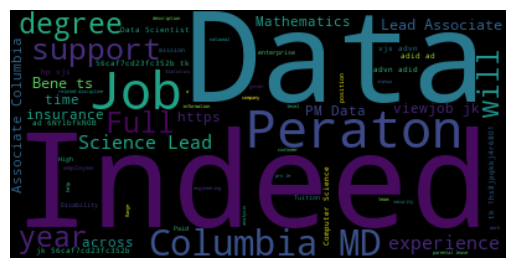

In [30]:
quick_wordcloud(example_indeed);

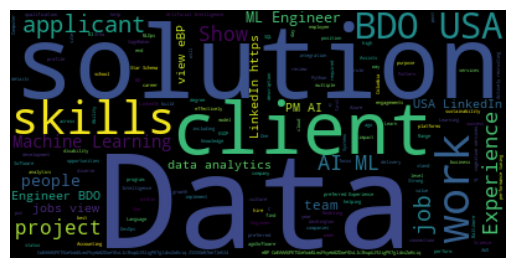

In [31]:
quick_wordcloud(example_linkedin);

## N-gram and FreqDist 

In [42]:
import pandas as pd
import nltk
def get_ngram_measures_df(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words', return_finder_measures = False,
                         group_name = None, join_words = True, sep= " ", multi_index=False):
    """
    Return the desired ngrams dataframe of requested measure. 
    Alternatively, return the finder and measure classes.

    This function will be used as a helper function for a comparison function.
    """
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    # instantiate the selected MeasuresClass
    measures = MeasuresClass()
    # instantiate a Finder
    finder = FinderClass.from_words(tokens)
    # Apply frequency filtering
    finder.apply_freq_filter(min_freq)

    # Return finder and measures instead of 
    if return_finder_measures == True:
        return finder, measures

    # Select desired measure to return
    selected_measure = getattr(measures, measure)
    scored_ngrams = finder.score_ngrams(selected_measure)

    if group_name is not None:
        suffix = group_name.title()
        measure_name = f"{measure.replace('_',' ').title()}"

        if multi_index == True:
            columns =  pd.MultiIndex.from_arrays([(suffix,suffix),(words_colname,measure_name )])
        else:
            columns = [f"{words_colname} ({suffix})", f"{measure_name} ({suffix})"]
    else:
        columns=[words_colname, measure.replace('_',' ').title()]
    # Convert the Scored n-grams to a dataframe
    df_ngrams = pd.DataFrame(scored_ngrams, columns=columns)

    # Clean up ngrams 
    if join_words == True:
        df_ngrams[columns[0]] = df_ngrams[columns[0]].map(sep.join)
    
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams



In [55]:
## FreqDist
import string
stopwords_list = [*STOPWORDS, *string.punctuation ]
tokens = nltk.casual_tokenize(example_indeed)
tokens_clean = [t.lower() for t in tokens if t not in STOPWORDS]
freqdist = nltk.FreqDist(tokens_clean)
freqdist

FreqDist({',': 84, '.': 34, 'data': 24, '\x00': 22, '/': 17, '-': 14, 'science': 11, 'peraton': 10, 'columbia': 10, 'md': 10, ...})

In [54]:
measures = nltk.BigramAssocMeasures()
finder = nltk.BigramCollocationFinder.from_words(nltk.casual_tokenize(example_indeed))
scored_ngrams = finder.score_ngrams(measures.pmi)
scored_ngrams

[(('#AJCM', 'Target'), 10.228818690495881),
 (('1880', 'hours'), 10.228818690495881),
 (('25', 'days'), 10.228818690495881),
 (('284', 'reviews'), 10.228818690495881),
 (('3/5', 'Quali'), 10.228818690495881),
 (('4', 'What'), 10.228818690495881),
 (('4/5', 'us'), 10.228818690495881),
 (('Apply', 'now'), 10.228818690495881),
 (('Companies', 'Salaries'), 10.228818690495881),
 (('Company', 'Apply'), 10.228818690495881),
 (('Cyber', 'Mission'), 10.228818690495881),
 (('EEO', 'An'), 10.228818690495881),
 (('Each', 'day'), 10.228818690495881),
 (('Education', '4'), 10.228818690495881),
 (('Enterprise', 'level'), 10.228818690495881),
 (('Events', 'Work'), 10.228818690495881),
 (('Extract', 'Transform'), 10.228818690495881),
 (('Fort', 'Meade'), 10.228818690495881),
 (('Here', '’'), 10.228818690495881),
 (('Hiring', 'Lab'), 10.228818690495881),
 (('Holidays', 'Retirement'), 10.228818690495881),
 (('IT', 'provider'), 10.228818690495881),
 (('Intelligence', 'Community'), 10.228818690495881),
 ((

### Interactive Wordclouds

In [21]:
import plotly.express as px

In [32]:
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go

def plotly_wordcloud(text):
    """SOURCE: https://github.com/PrashantSaikia/Wordcloud-in-Plotly/blob/master/plotly_wordcloud.py"""
    wc = WordCloud(stopwords = set(STOPWORDS),
                   max_words = 200,
                   max_font_size = 100)
    wc.generate(text)
    
    word_list=[]
    freq_list=[]
    fontsize_list=[]
    position_list=[]
    orientation_list=[]
    color_list=[]

    for (word, freq), fontsize, position, orientation, color in wc.layout_:
        word_list.append(word)
        freq_list.append(freq)
        fontsize_list.append(fontsize)
        position_list.append(position)
        orientation_list.append(orientation)
        color_list.append(color)
        
    # get the positions
    x=[]
    y=[]
    for i in position_list:
        x.append(i[0])
        y.append(i[1])
            
    # get the relative occurence frequencies
    new_freq_list = []
    for i in freq_list:
        new_freq_list.append(i*100)
    new_freq_list
    
    trace = go.Scatter(x=x, 
                       y=y, 
                       textfont = dict(size=new_freq_list,
                                       color=color_list),
                       hoverinfo='text',
                       hovertext=['{0}{1}'.format(w, f) for w, f in zip(word_list, freq_list)],
                       mode='text',  
                       text=word_list
                      )
    
    layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
    
    fig = go.Figure(data=[trace], layout=layout)
    
    return fig# px.wordcloud(job)

In [35]:
wc = WordCloud(stopwords = set(STOPWORDS))
cloud = wc.generate_from_text(example_linkedin)

In [41]:
# wc.layout_

In [40]:
# fig = plotly_wordcloud(example_linkedin)
# fig